# Ridge回帰

正則化項にパラメータの二乗和を用いた線形回帰モデル。L2正則化とも呼ばれる。Ridgeの読み方はリッジ。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
np.random.seed(11)

x_range = (-1, 2.5)
def get_samples(n):
    x = np.random.uniform(*x_range, n)
    y = np.sin(x) + 0.2 * np.random.randn(n)
    return x.reshape(-1, 1), y

def evaluate(model, X_train, X_test, y_train, y_test):
    score_train = r2_score(y_train, model.predict(X_train))
    score_test = r2_score(y_test, model.predict(X_test))
    print(f"score (train): {score_train:.2f}")
    print(f"score (test): {score_test:.2f}")

    x_axis = np.linspace(*x_range, 100).reshape(-1, 1)
    y_pred = model.predict(x_axis)
    plt.scatter(X_train, y_train, label="train")
    plt.scatter(X_test, y_test, label="test")
    plt.plot(x_axis, y_pred, color="red", label="trained model")
    plt.ylim(-2, 2)
    plt.legend()

Ridge回帰では、パラメータの二乗和がモデルの複雑さを表すと仮定する。

$$
\begin{align}
R(\bm\theta) &= \sum_{i=1}^m \theta_i^2 = \|\bm\theta\|_2^2 \\
\bm\theta&\in\mathbb{R}^m
\end{align}
$$

目的関数は以下のようになる。

$$
\begin{align}
J(\bm w)
    &= \| \bm y - \bm X \bm w \|_2^2 + \alpha R(\bm w) \\
    &= \| \bm y - \bm X \bm w \|_2^2 + \alpha \| \bm w \|_2^2 \\
\end{align}
$$

これを解く。

解き方は同じで、微分して0になる点を求めるだけ。

一つ目の項の微分は前章で求めているので、そこに正則化項の微分を足す。

$$
\begin{align}
\frac{\partial J}{\partial \bm w}
	&= -2X^T\bm y + 2X^TX\bm w + \frac{\partial}{\partial \bm w}\alpha\|\bm w\|_2^2 \\
	&= -2X^T\bm y + 2X^TX\bm w + 2\alpha\bm w
\end{align}
$$

これが0になる点を求める。

$$
\begin{align}
-2X^T\bm y + 2X^TX\bm w + 2\alpha\bm w &= 0 \\
X^TX\bm w + \alpha\bm w &= X^T\bm y \\
X^TX\bm w + \alpha I\bm w &= X^T\bm y \\
(X^TX\bm + \alpha I)\bm w &= X^T\bm y \\
\bm w &= (X^TX + \alpha I)^{-1}X^T\bm y
\end{align}
$$

おわり。$\alpha I$が足されただけ。$I$は単位行列。

実装してみる。

In [2]:
class RidgeRegression:
    def __init__(self, alpha=1.):
        self.alpha = alpha
        self.weights = None

    def fit(self, X, y):
        X = np.insert(X, 0, 1, axis=1)
        I = np.identity(X.shape[1], dtype=np.float32)
        I[0, 0] = 0 # バイアス項は無視
        self.weights = np.linalg.inv(X.T @ X + self.alpha*I) @ X.T @ y

    def predict(self, X):
        X = np.insert(X, 0, 1, axis=1)
        return X @ self.weights

バイアスに当たる$w_0$は正則化しない。しても過学習の抑制につながらないため。

$\alpha I$の$w_0$に対応する部分を0にすることで$w_0$については通常の線形回帰と同じ値になるため、正則化をしないことと同じ意味になる。

これを学習させてみる。

score (train): 0.96
score (test): 0.80


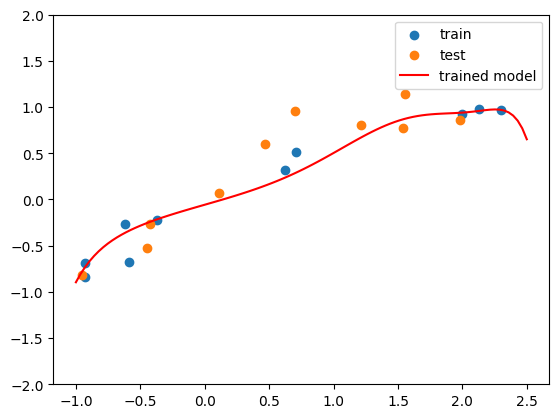

In [3]:
X, y = get_samples(20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=11
)
poly = PolynomialFeatures(degree=10, include_bias=False)
model = RidgeRegression(alpha=1.)
pipeline = Pipeline([("poly", poly), ("model", model)])
pipeline.fit(X_train, y_train)
evaluate(pipeline, X_train, X_test, y_train, y_test)

先ほどは過学習を起こしていた場面（少ないデータ&複雑なモデル）だが、正則化によって過学習が抑制された。

sklearnの結果とも一致している。

In [4]:
model.weights[0], model.weights[1:]

(-0.056882393717984966,
 array([ 0.40124286,  0.00346738,  0.17651165, -0.02504002,  0.06774456,
        -0.0566288 ,  0.01344915, -0.05335136,  0.04055918, -0.00801199]))

In [5]:
from sklearn.linear_model import Ridge
correct_model = Ridge(alpha=1.)
pipeline = Pipeline([("poly", poly), ("model", correct_model)])
pipeline.fit(X_train, y_train)
pipeline["model"].intercept_, pipeline["model"].coef_

(-0.05688239362246052,
 array([ 0.40124286,  0.00346738,  0.17651165, -0.02504002,  0.06774456,
        -0.0566288 ,  0.01344915, -0.05335136,  0.04055918, -0.00801199]))